# Download genres from DBPedia

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
from pprint import pp
import ssl
import os
from tqdm import tqdm
import json

ssl._create_default_https_context = ssl._create_unverified_context

## Query DBpedia

In [2]:
def query(q):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    prefix = '''
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX dbpedia: <http://dbpedia.org/resource/>
        PREFIX foaf: <http://xmlns.com/foaf/0.1/>
        PREFIX dct: <http://purl.org/dc/terms/>
        PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX dbr: <http://dbpedia.org/resource/>
        PREFIX dbo: <http://dbpedia.org/ontology/>
        PREFIX dbc: <http://dbpedia.org/resource/Category:>
        PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>
        
        PREFIX ouseful:<http://ouseful.info/>
    '''
    sparql.setQuery(prefix+q)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()["results"]["bindings"]

In [3]:
q = """

SELECT DISTINCT ?g

WHERE {
    ?g rdf:type dbo:MusicGenre .
    dbr:Progressive_rock dbo:musicSubgenre ?g .
}
"""

pp(query(q))

[{'g': {'type': 'uri',
        'value': 'http://dbpedia.org/resource/Canterbury_scene'}},
 {'g': {'type': 'uri',
        'value': 'http://dbpedia.org/resource/Neo-progressive_rock'}},
 {'g': {'type': 'uri',
        'value': 'http://dbpedia.org/resource/Rock_in_Opposition'}}]


In [4]:
q = """

SELECT DISTINCT ?g

WHERE {
    ?g rdf:type dbo:MusicGenre .
     ?g dbo:musicSubgenre dbr:Progressive_rock .
}
"""

pp(query(q))

[{'g': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Rock_music'}}]


## Get genres (main pages)

In [5]:
def get_redirects():
    q = """
    SELECT DISTINCT ?main ?redirect
    WHERE {
        ?main rdf:type dbo:MusicGenre .
        ?main rdfs:label ?l .
        OPTIONAL {
            ?redirect rdf:type dbo:MusicGenre .
            ?redirect dbo:wikiPageRedirects ?main .
        }
    }
    """
    res = query(q)
    red = dict()
    for r in res:
        if 'redirect' in r:
            red[r['redirect']['value']] = r['main']['value']
    return red

red = get_redirects()

def recurse_red(elem):
    if elem in red:
        return recurse_red(red[elem])
    return elem

In [6]:
def search_genre(genre):
    q = """
    SELECT DISTINCT ?main
    WHERE {
        ?main rdf:type dbo:MusicGenre .
        ?main rdfs:label ?l .
        """+'\n'.join('FILTER contains(lcase(?l), \"'+w.lower()+'\")' for w in genre.split()) + """
        FILTER langMatches( lang(?l), "en" )
    }
    """
    
    return list(set(recurse_red(e['main']['value']) for e in query(q)))

pp(search_genre("Jazz"))

['http://dbpedia.org/resource/Gypsy_jazz',
 'http://dbpedia.org/resource/Samba-jazz',
 'http://dbpedia.org/resource/British_jazz',
 'http://dbpedia.org/resource/List_of_1920s_jazz_standards',
 'http://dbpedia.org/resource/Continental_jazz',
 'http://dbpedia.org/resource/Twelve-bar_blues',
 'http://dbpedia.org/resource/Jazz_poetry',
 'http://dbpedia.org/resource/List_of_jazz_genres',
 'http://dbpedia.org/resource/Jazz-pop',
 'http://dbpedia.org/resource/Vocal_jazz',
 'http://dbpedia.org/resource/Jazz_standard',
 'http://dbpedia.org/resource/Jazz_band',
 'http://dbpedia.org/resource/West_Coast_jazz',
 'http://dbpedia.org/resource/European_free_jazz',
 'http://dbpedia.org/resource/Modal_jazz',
 'http://dbpedia.org/resource/Latin_jazz',
 'http://dbpedia.org/resource/Jazz_flamenco',
 'http://dbpedia.org/resource/Jazz_house',
 'http://dbpedia.org/resource/Gypsy_Jazz',
 'http://dbpedia.org/resource/Jazz_piano',
 'http://dbpedia.org/resource/Jazz_flute',
 'http://dbpedia.org/resource/Crossover

## Create mapping

In [7]:
# MANUAL FIXES

# with open('discogs/genres.json') as f:
#     genres = json.load(f)

# m = dict()
# for genre in tqdm(genres.keys()):
#     m[genre] = search_genre(genre.replace('+', ' '))

# os.makedirs('dbpedia', exist_ok=True)
# with open('dbpedia/genres2dbpedia_iri.json', 'w') as f:
#     json.dump(m, f)

In [8]:
# with open('dbpedia/genres2dbpedia_iri.json','r') as f:
#     m = {k:v[0] for k,v in json.load(f).items()}

# with open('dbpedia/genres2dbpedia_iri.json','w') as f:
#     json.dump(m, f)

## Subgenres

In [34]:
properties = {'derivative':False, 'musicFusionGenre':False, 'stylisticOrigin':True, 'musicSubgenre':False}

In [35]:
def get_genres_relation(property):
    q = """
    SELECT DISTINCT ?fst ?snd
    WHERE {
        ?fst rdf:type dbo:MusicGenre .
        ?snd rdf:type dbo:MusicGenre .
        ?fst dbo:"""+property+""" ?snd .
    }
    """
    return [(r['fst']['value'],r['snd']['value']) for r in query(q)]
    

property_dict = {p:get_genres_relation(p) for p in properties}

## Display graph of genres

In [70]:
import networkx as nx
import matplotlib.pyplot as plt

{'political',
 'public+broadcast',
 'romantic',
 'score',
 'soundtrack',
 'stage+&+screen',
 'theme',
 'vocal'}


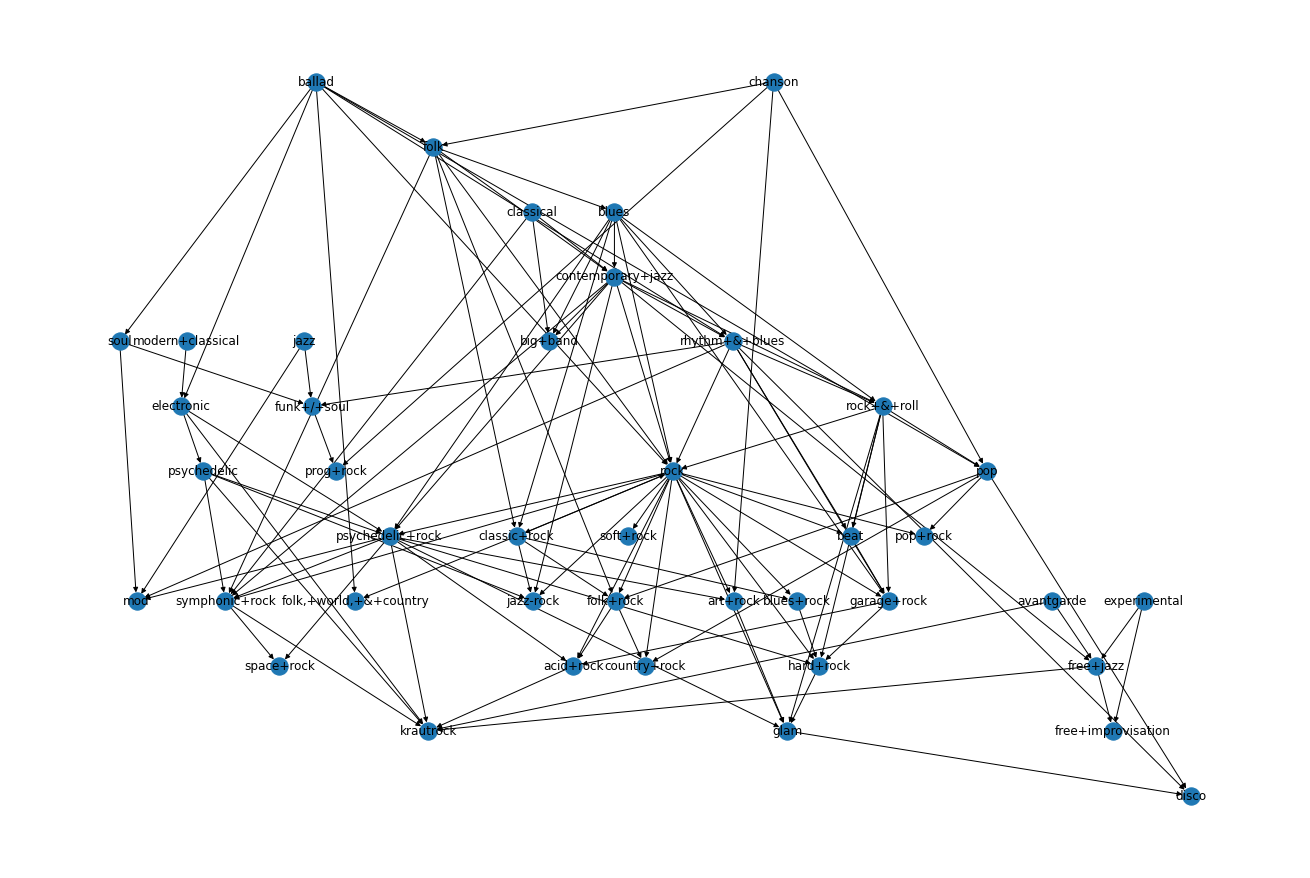

In [72]:
with open('dbpedia/genres2dbpedia_iri.json','r') as f:
        genres = set(json.load(f).values())
        f.seek(0,0)
        dbpedia2name = {v:k for k,v in json.load(f).items()}
    
G = nx.DiGraph()
for p, flip in properties.items():
    for fst, snd in property_dict[p]:
        if fst in genres and snd in genres:
            if flip:
                fst, snd = snd, fst
            if fst == snd:
                continue
            G.add_edge(dbpedia2name[fst], dbpedia2name[snd])

# mod
G.add_edge('jazz','mod')
G.add_edge('rhythm+&+blues','mod')
G.add_edge('psychedelic+rock','mod')
G.add_edge('soul','mod')

# ballad
G.add_edge('ballad','pop')
G.add_edge('ballad', 'rhythm+&+blues')
G.add_edge('ballad','folk')
G.add_edge('ballad','soul')
G.add_edge('ballad','folk,+world,+&+country')
G.add_edge('ballad','rock')
G.add_edge('ballad','electronic')

# chanson
G.add_edge('chanson','pop')
G.add_edge('chanson','folk')
G.add_edge('chanson','prog+rock')
G.add_edge('chanson','art+rock')

# classic rock
G.add_edge('classic+rock','rock')
G.add_edge('classic+rock','jazz-rock')
G.add_edge('classic+rock','blues+rock')
G.add_edge('classic+rock','folk+rock')
G.add_edge('classic+rock','folk,+world,+&+country')
G.add_edge('blues','classic+rock')
G.add_edge('folk','classic+rock')
G.add_edge('rock','classic+rock')

# funk+/+soul
G.add_edge('soul', 'funk+/+soul')
G.add_edge('jazz', 'funk+/+soul')
G.add_edge('rhythm+&+blues', 'funk+/+soul')
G.add_edge('funk+/+soul', 'prog+rock')

plt.figure(figsize=(18,12))
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True)

pp(set(dbpedia2name[e] for e in genres).difference(set(G.nodes)))